In [1305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, binom, t, chi2_contingency, shapiro, levene, iqr, ttest_ind, kstest
import datetime as dt
import plotly.express as px
import calendar
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [707]:
df = pd.read_csv('https://**')

<h2 style="color:purple;">Problem Statement</h2>

<h4>Study the provided Dataset with raw sensor timestamp data. Do a quality check, then separate out individual features out of the combined feature columns to have a clarified set. Based on this, set aggregation rules based on the features and perform aggregation to reduce repatitive rows for clearer understanding. </h4>
<h4>Then use the new dataframe for performing feature based exploration and calculated vs recorded feature comparisons for understanding the accuracy of the sensors.</h4>
<h4>Now, with the individual features, the companies logistics should be analysed based on the city/state/route type alongwith insights about the numerical parameters and what leads to increased delivery time vs what reduces it</h4>

<h2 style = "color:purple;" >Data Quality Check</h2>

In [710]:
df.shape

(144867, 24)

In [711]:
for c in df.columns:
    if c not in ['segment_actual_time', 'segment_osrm_time', 'actual_time', 'osrm_time']:
        if c.endswith("_time") or c.endswith("_timestamp"):
            df[c] = pd.to_datetime(df[c])

<h3>Missing Values & Duplicates</h3>

In [712]:
d = pd.DataFrame(df.dtypes)
d['Null counts'] = df.isnull().sum()
d

,0,Null counts
data,object,0
trip_creation_time,datetime64[ns],0
route_schedule_uuid,object,0
route_type,object,0
trip_uuid,object,0
source_center,object,0
source_name,object,293
destination_center,object,0
destination_name,object,261
od_start_time,datetime64[ns],0


In [713]:
#function for filling missing values based on the string type functions
def fill_missing_values(check_var, fix_var, dfi):
    fill_idxs = dfi[dfi[fix_var].isnull()].index.values #storing index of missing values in the feature
    c, i = 0, -1 #initialising counter c for traversing array 'fill_idxs' and i for df
    while c<len(fill_idxs) and i<len(dfi):
        i+=1
        if str(dfi[fix_var][i])=='nan':
            continue #ignoring rows which have missing values while traversing df
        elif dfi[check_var][fill_idxs[c]][:5] == dfi[check_var][i][:5]: #comparing first 5 letters of the source centers
            dfi[fix_var][fill_idxs[c]] = dfi[fix_var][i] #if the first 5 letters match, 
            #then assign corresponding source name value to the index of the missing value
            c+=1 #increment fill_idxs index counter when a value is filled
    return dfi

In [714]:
df = fill_missing_values('source_center', 'source_name', df)
df = fill_missing_values('destination_center', 'destination_name', df)

In [715]:
df.isnull().sum()

data                              0
trip_creation_time                0
route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
od_start_time                     0
od_end_time                       0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
cutoff_timestamp                  0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
dtype: int64

In [716]:
df.duplicated().sum()

0

<h2 style = "color:red;">Observation</h2>
<h4>There are 1,44,867 rows and 24 columns.</h4>
<h4>8 columns of Datetime type, 6 float64, 1 boolean, 1 int64 and 8 Object type.</h4>
<h4>'source_name' has 293 missing values and 'destination_name' has 261 missing values</h4>
<h4>Missing values for both variables were treated with the closest possible reference</h4>
<h4>There are no duplicated rows</h4>

In [717]:
for c in df.columns:
    print(c, df[c].nunique(), sep = ': ')

data: 2
trip_creation_time: 14817
route_schedule_uuid: 1504
route_type: 2
trip_uuid: 14817
source_center: 1508
source_name: 1498
destination_center: 1481
destination_name: 1468
od_start_time: 26369
od_end_time: 26369
start_scan_to_end_scan: 1915
is_cutoff: 2
cutoff_factor: 501
cutoff_timestamp: 93180
actual_distance_to_destination: 144515
actual_time: 3182
osrm_time: 1531
osrm_distance: 138046
factor: 45641
segment_actual_time: 747
segment_osrm_time: 214
segment_osrm_distance: 113799
segment_factor: 5675


<h2 style="color:purple;">Data Processing and Aggregation</h2>

In [718]:
#removing sensor/scanner assgined string from the actual values
df['trip_uuid']=df['trip_uuid'].apply(lambda x: x.split('-')[1])
df['route_schedule_uuid'] = df['route_schedule_uuid'].apply(lambda x: x.split(':')[-1])

<h4>Dropping Unknown & Insignificant Fields</h4>

In [719]:
df.drop(columns = ['route_schedule_uuid','is_cutoff', 'cutoff_factor', 'cutoff_timestamp', 'factor', 'segment_factor'], inplace = True)

In [720]:
#storing non-cummulative columns into a dataframe to fix original dataframe columns
convert_cumu = df.groupby(by = ['trip_uuid', 'source_center', 'destination_center']).cumsum()[['segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance']]

In [721]:
for c in convert_cumu.columns:
    df[c] = convert_cumu[c]

<h4>All numerical columns in the dataframe are now in cummulative sum formats or fixed values based on the category</h4>

In [722]:
dfcopy = df.copy()

In [723]:
df = df.groupby(by = ['trip_uuid', 'source_center', 'destination_center']).max()

In [724]:
df_agg = df.groupby(level=0).sum().reset_index()

<h3>Feature Engineering</h3>

In [725]:
#storing separated day, month, year values for each row based on the trip creation
df_agg['trip_year'] = df['trip_creation_time'].dt.year.groupby(level=0).min().reset_index()['trip_creation_time']
df_agg['trip_month'] = df['trip_creation_time'].dt.month.groupby(level=0).min().reset_index()['trip_creation_time']
df_agg['trip_day'] = df['trip_creation_time'].dt.day.groupby(level=0).min().reset_index()['trip_creation_time']
#storing difference of od_start_time and od_end_time to get total trip time from start point to end point
df_agg['total_trip_time'] = round(\
((df.groupby(level=0)['od_end_time'].max()-df.groupby(level=0)['od_start_time'].min()).dt.seconds/60),0).reset_index()[0]\
+\
(((df.groupby(level=0)['od_end_time'].max()-df.groupby(level=0)['od_start_time'].min())).dt.days*24*60).reset_index()[0]

<h4>Extracting state,city and area name for source and destination from grouped trip_uuid dataframe using the last & first occurrences respectively as dataframe is reverse ordered</h4>


In [726]:
df_agg['source_state'] = None
df_agg['source_city'] = None
df_agg['source_area_code'] = None
df_agg['destination_state'] = None
df_agg['destination_city'] = None
df_agg['destination_area_code'] = None

In [727]:
s_state_ser = df.groupby(level=0)['source_name'].last().str.split('(').reset_index()['source_name']
s_city_ser = df.groupby(level=0)['source_name'].last().str.split('_').reset_index()['source_name']
d_state_ser = df.groupby(level=0)['destination_name'].first().str.split('(').reset_index()['destination_name']
d_city_ser = df.groupby(level=0)['destination_name'].first().str.split('_').reset_index()['destination_name']
for i in range(len(df_agg)):
    df_agg['source_state'][i] = s_state_ser[i][1][:-1]
    df_agg['source_city'][i] = s_city_ser[i][0].split('(')[0]
    if "-".join(s_city_ser[i][1:]).split('(')[0] == "":
        df_agg['source_area_code'][i] = s_city_ser[i][0].split('(')[0][:-1]
    else:
        df_agg['source_area_code'][i] = "-".join(s_city_ser[i][1:]).split('(')[0]
    df_agg['destination_state'][i] = d_state_ser[i][1][:-1]
    df_agg['destination_city'][i] = d_city_ser[i][0].split('(')[0]
    if "-".join(d_city_ser[i][1:]).split('(')[0] == "":
        df_agg['destination_area_code'][i] = d_city_ser[i][0].split('(')[0][:-1]
    else:
        df_agg['destination_area_code'][i] = "-".join(d_city_ser[i][1:]).split('(')[0]

In [728]:
#changing numeric month values to month names for ease of understanding
month = month.fromkeys(np.arange(1,13))
month = dict(zip(month,list(calendar.month_name)[1:]))
for i in range(len(df_agg)):
    df_agg['trip_month'][i] = month[df_agg['trip_month'][i]]

In [729]:
df_agg['route_type'] = df['route_type'].groupby(level=0).min().reset_index()['route_type']

In [731]:
for i in df_agg[df_agg['source_city']=='Bangalore']['source_city'].index:
    df_agg['source_city'][i] = 'Bengaluru'
for i in df_agg[df_agg['destination_city']=='Bangalore']['destination_city'].index:
    df_agg['destination_city'][i] = 'Bengaluru'

In [902]:
#extracting list of urban cities in india
metro = pd.read_html('https://en.wikipedia.org/wiki/List_of_metropolitan_areas_in_India', )[0]['Metropolitan area']
metro = list(metro['Metropolitan area'].values)
metro.remove('National Capital Region')
metro.remove('Bangalore')
metro = metro + ['Bengaluru','Delhi', 'Noida', 'Greater Noida','FBD','Gurgaon','Alwar','Ghaziabad']

In [904]:
df_agg['source_urban'] = None 
df_agg['destination_urban'] = None 
for i in range(len(df_agg)):
    if df_agg['source_city'][i] in metro:
        df_agg['source_urban'][i] = 1
    else: 
        df_agg['source_urban'][i] = 0
    if df_agg['destination_city'][i] in metro:
        df_agg['destination_urban'][i] = 1
    else: 
        df_agg['destination_urban'][i] = 0 

In [1033]:
df_agg.rename(columns = {'start_scan_to_end_scan': 'scanner_start_to_end_time'}, inplace = True)

In [1034]:
for c in df_agg.columns:
    if c.endswith('time'):
        df_agg[c] = round(df_agg[c]/60,2)

<h4>Aggregated DataFrame is ready for EDA</h4>

In [1035]:
df_agg.isna().sum()

trip_uuid                         0
scanner_start_to_end_time         0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
trip_year                         0
trip_month                        0
trip_day                          0
total_trip_time                   0
source_state                      0
source_city                       0
source_area_code                  0
destination_state                 0
destination_city                  0
destination_area_code             0
route_type                        0
source_urban                      0
destination_urban                 0
dtype: int64

In [1036]:
df_agg.duplicated().sum()

0

In [1037]:
df_agg.shape

(14817, 22)

<h2 style = "color:red;">Observation</h2>
<h4>There  are no duplicates or missing values in the aggregated dataframe</h4>
<h4>Final dataframe has 14817 unique rows corresponding to each trip and 20 single feature columns</h4>

In [1038]:
df_agg.describe()

,scanner_start_to_end_time,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,trip_year,trip_day,total_trip_time
count,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.0,14817.000000,14817.00000
mean,8.846829,164.683253,5.952251,2.701142,205.101357,5.898159,3.015824,223.201161,2018.0,18.370790,9.12447
std,10.978427,305.561572,9.356571,4.538387,370.780010,9.270815,5.242388,416.628374,0.0,7.893275,11.14481
min,0.380000,9.002461,0.150000,0.100000,9.072900,0.150000,0.100000,9.072900,2018.0,1.000000,0.38000
25%,2.480000,22.860030,1.120000,0.480000,30.941800,1.100000,0.520000,32.654500,2018.0,14.000000,2.52000
50%,4.670000,48.499937,2.480000,1.000000,65.882600,2.450000,1.080000,70.154400,2018.0,19.000000,4.82000
75%,10.620000,164.853324,6.170000,2.820000,209.300500,6.120000,3.080000,218.802400,2018.0,25.000000,11.22000
max,131.630000,2187.483994,104.420000,33.870000,2840.081000,103.830000,42.730000,3523.632400,2018.0,30.000000,131.65000


<h2 style = "color:red;">Observation</h2>
<h4>Average trip time is 547 minutes, almost twice of the median value. This indicates outliers or largely sparse data for a certain category</h4>
<h4>Trip distances have ranged from 9kms to 2187 kms with an average of 164 kms</h4>

In [1039]:
df_agg.dtypes

trip_uuid                          object
scanner_start_to_end_time         float64
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
trip_year                           int64
trip_month                         object
trip_day                            int64
total_trip_time                   float64
source_state                       object
source_city                        object
source_area_code                   object
destination_state                  object
destination_city                   object
destination_area_code              object
route_type                         object
source_urban                       object
destination_urban                  object
dtype: object

In [1040]:
print("No. of unique values")
for c in df_agg.columns:
    print(c, df_agg[c].nunique(), sep = ': ')

No. of unique values
trip_uuid: 14817
scanner_start_to_end_time: 2208
actual_distance_to_destination: 14801
actual_time: 1853
osrm_time: 830
osrm_distance: 14736
segment_actual_time: 1890
segment_osrm_time: 1242
segment_osrm_distance: 14754
trip_year: 1
trip_month: 2
trip_day: 22
total_trip_time: 2260
source_state: 31
source_city: 885
source_area_code: 898
destination_state: 32
destination_city: 869
destination_area_code: 869
route_type: 2
source_urban: 2
destination_urban: 2


In [1041]:
print("No. of unique values")
for c in df_agg.columns:
    print(c, df_agg[c].value_counts(), sep = ':\n')

No. of unique values
trip_uuid:
153671041653548748    1
153791331656620454    1
153791340002649773    1
153791341220571147    1
153791345208672550    1
                     ..
153730385530436915    1
153730387256906443    1
153730391233462064    1
153730396484038671    1
153861118270144424    1
Name: trip_uuid, Length: 14817, dtype: int64
scanner_start_to_end_time:
2.47     51
1.92     51
2.13     50
1.45     50
1.88     49
         ..
30.62     1
21.83     1
44.07     1
70.22     1
36.33     1
Name: scanner_start_to_end_time, Length: 2208, dtype: int64
actual_distance_to_destination:
195.620460    2
27.959967     2
26.581610     2
23.034042     2
15.807111     2
             ..
76.176597     1
101.057716    1
19.706255     1
234.225228    1
66.081533     1
Name: actual_distance_to_destination, Length: 14801, dtype: int64
actual_time:
1.00     134
0.83     130
0.70     122
0.80     114
0.63     111
        ... 
40.53      1
26.92      1
17.77      1
18.45      1
27.90      1
Name: actu

<h2 style = "color:red;">Observation</h2>
<h4>1. Data belongs to trips occurred only in the year 2018</h4>
<h4>2. 13029 trips occurred in September, 1788 in October, data was gather for a period of 2 months in the same year</h4>
<h4>3. Most popular source state is Maharashtra, then Karnataka and least popular is Tripura</h4>
<h4>4. Most popular source city is Bengaluru, then Gurgaon and least popular is Anandnager,etc</h4>
<h4>5. Most popular destination state is Maharashtra, then Karnataka and least popular is Daman & diu</h4>
<h4>6. Most popular destination city is Bengaluru, then Mumbai and least popular is Kapadvanj</h4>
<h4>7. 8908 datapoints are from carting, 5909 from FTL route-type</h4>
<h4>8. 8633 trips started from non-metropolitan cities, 6184 from metropolitan.</h4>
<h4>9. 8591 trips ended at non-metropolitan cities and 6226 in metropolitan.</h4>


<h4>Since, months comprises of only 2 months, it can be considered as a nominal variable like route_type and one hot encoded.</h4>

<h3>One hot Encoding for Route_type and Trip_month</h4>

In [1043]:
from category_encoders import TargetEncoder
te = TargetEncoder()

In [1044]:
dfn = pd.get_dummies(df_agg,columns=['route_type', 'trip_month'], drop_first=True)

In [1045]:
col_cat = [x for x in dfn.columns if x.startswith('source') or x.startswith('destination')]
col_con = [x for x in df_agg.columns if df_agg[x].dtype != 'O']

In [1046]:
#performing target encoding on Categorical variables like city,state and area using the route_type value 
for c in col_cat:
    dfn[c] = te.fit_transform(dfn[c], dfn['route_type_FTL'])

<h4>df_agg is aggregated column including categorical variables and dfn is the aggregated column with all numeric features</h4>

<h3>Outlier Detection & Treatment</h3>

In [1047]:
def outlier_percentage(data, c):
    p75 = np.percentile(data[c], 75)
    p25 = np.percentile(data[c], 25)
    IQR = 1.5*iqr(data[c])
    u = p75 + IQR
    l = p25 - IQR
    if l<0:
        l = np.percentile(data[c], 1)
    d = data[(data[c]>u) | (data[c]<l)]
    n = len(d)/len(data)
    return round(n*100,2),l,u

In [1048]:
print('Percentage of Outliers in the features')
lb, ub = {},{}
for c in col_con:
    p,lb[c],ub[c]=outlier_percentage(df_agg, c)
    print(c, p, sep = ': ')

Percentage of Outliers in the features
scanner_start_to_end_time: 9.5
actual_distance_to_destination: 10.78
actual_time: 12.07
osrm_time: 10.84
osrm_distance: 11.3
segment_actual_time: 11.93
segment_osrm_time: 10.81
segment_osrm_distance: 11.45
trip_year: 0.0
trip_day: 0.0
total_trip_time: 8.52


<AxesSubplot:xlabel='route_type', ylabel='actual_distance_to_destination'>

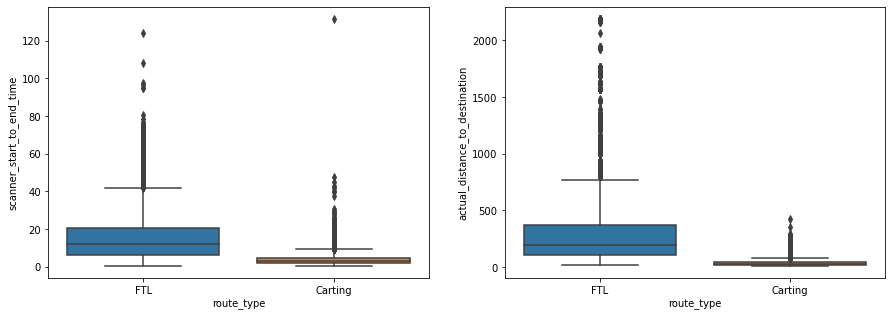

In [1049]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.boxplot(data = df_agg, y =col_con[0], x = 'route_type')
plt.subplot(1,2,2)
sns.boxplot(data = df_agg, y =col_con[1], x = 'route_type')

<h2 style = "color:red;">Observation</h2>
<h4>1. On Average 10% of data in all the continuous features are outliers</h4>
<h4>2. Outlier detection is performed based on route_type and it is seen that FTL routes generally have much larger median trip times and trip distances compared to Carting. Also have more outliers.</h4>
<h4>3. Since distance based outliers are much further spread out, it is understood that alot of outliers in trip time will be due to this. This can be checked using the independence tests like Chi2 test.</h4>
<h4>4. These outliers are not being treated, as each continuous feature has around 10% outliers and that can result in huge data loss. Also, the outliers can be analysed based on the source and destinations.</h4>

<h2 style="color:purple">EDA & Hypothesis Testing</h2>

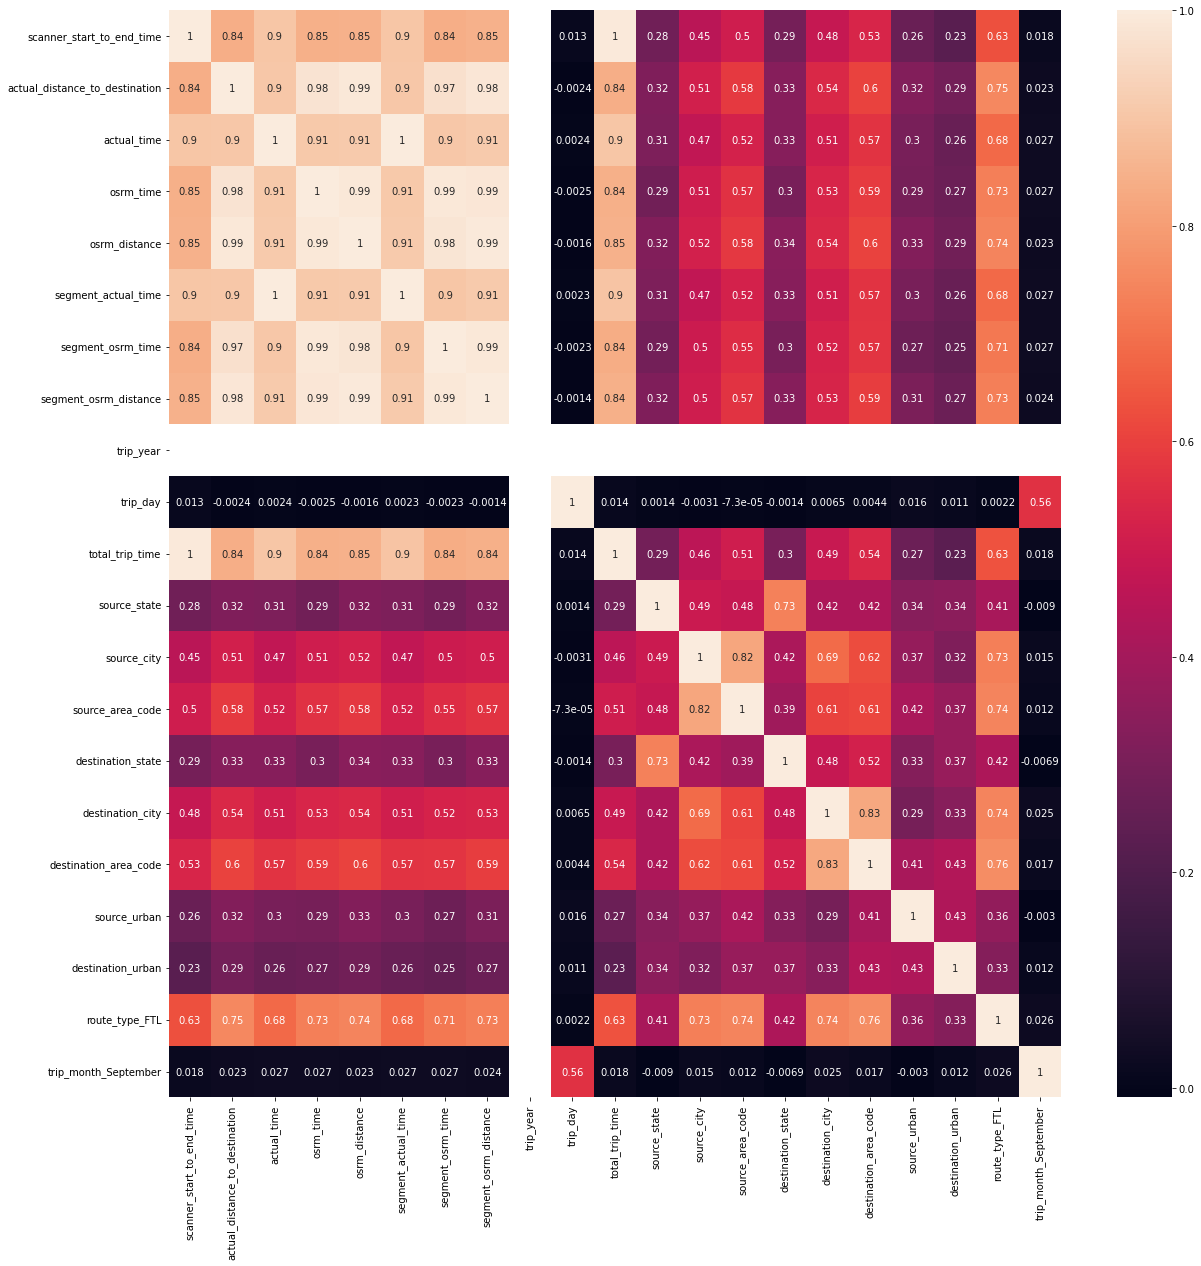

In [1050]:
plt.figure(figsize = (20,20))
sns.heatmap(dfn.corr(method = 'spearman'), annot = True, )
plt.show()

<h2 style = "color:red;">Observation</h2>
<h4>1. start scan to end scan shows a 1:1 correlation with calculated total trip time, this can be confirmed with a distribution and hypothesis test</h4>
<h4>2. Total trip time shows 84% correlation with distance variables, which is as expected</h4>
<h4>3. Route type also strongly affects trip time, as they have 63% correlation. This can checked with distance based  analysis on route categories</h4>
<h4>4. Urban sources and destinations have approximate 25% correlations with trip time, which indicates trip time is somewhat increasing based on the Metro cities, maybe due to more pit stops? or traffic problems. This can be confirmed with t-tests for 2 means</h4>

In [1051]:
df_agg.dtypes

trip_uuid                          object
scanner_start_to_end_time         float64
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
trip_year                           int64
trip_month                         object
trip_day                            int64
total_trip_time                   float64
source_state                       object
source_city                        object
source_area_code                   object
destination_state                  object
destination_city                   object
destination_area_code              object
route_type                         object
source_urban                       object
destination_urban                  object
dtype: object

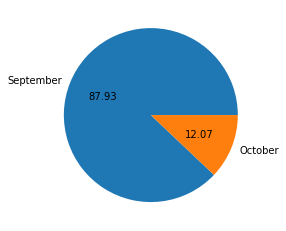

In [1052]:
plt.pie(df_agg['trip_month'].value_counts(), autopct = '%.2f', labels = df_agg['trip_month'].unique())
plt.show()

<h4>Data contains 88% of trips from september and 12% from october</h4>

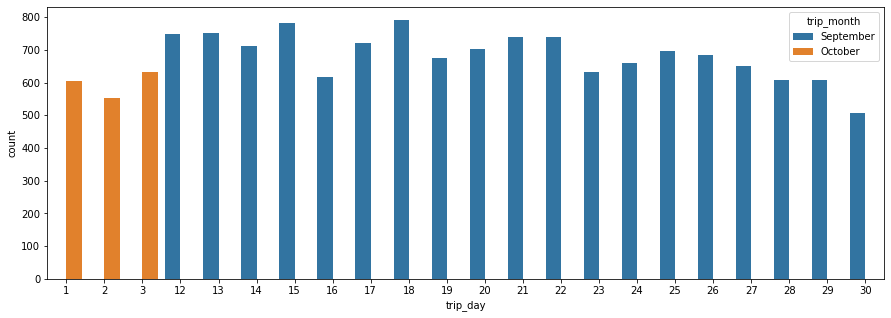

In [1053]:
plt.figure(figsize=(15,5))
sns.countplot(data = df_agg, x = 'trip_day', hue = 'trip_month')
plt.show()

<h4>October trips are only from the first 3 days of the month, while september trips are from 12-30th day of september</h4>

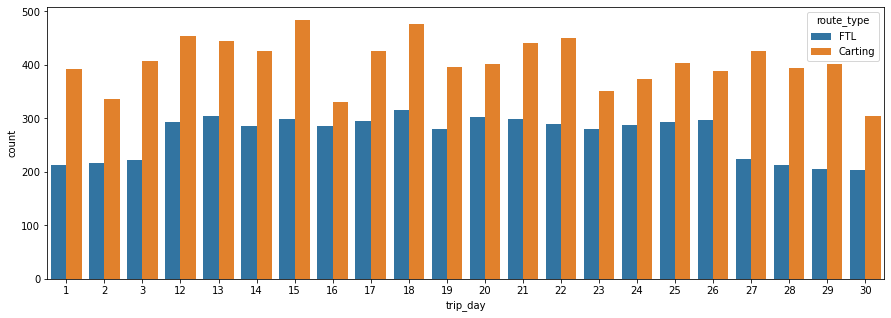

In [1054]:
plt.figure(figsize=(15,5))
sns.countplot(data = df_agg, x = 'trip_day', hue = 'route_type')
plt.show()

<AxesSubplot:xlabel='route_type', ylabel='total_trip_time'>

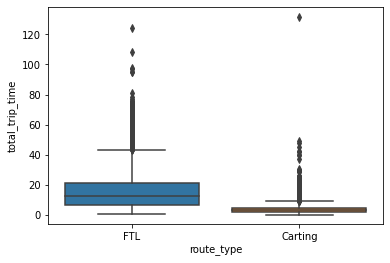

In [1203]:
sns.boxplot(y = df_agg['total_trip_time'], x = df_agg['route_type'])

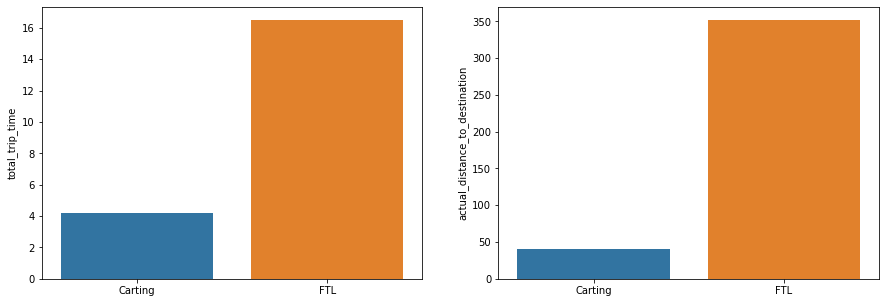

In [1055]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(y = df_agg.groupby('route_type')['total_trip_time'].mean(), x = ['Carting', 'FTL'])
plt.subplot(1,2,2)
sns.barplot(y = df_agg.groupby('route_type')['actual_distance_to_destination'].mean(), x = ['Carting', 'FTL'])
plt.show()

<h4>1. Full Truck load trips have a mean trip time of above 16 hours, and mean travel distances of 350 kms</h4>
<h4>2. Carting trips are shorter within 50kms distance and less than 5 hours of travel time</h4>

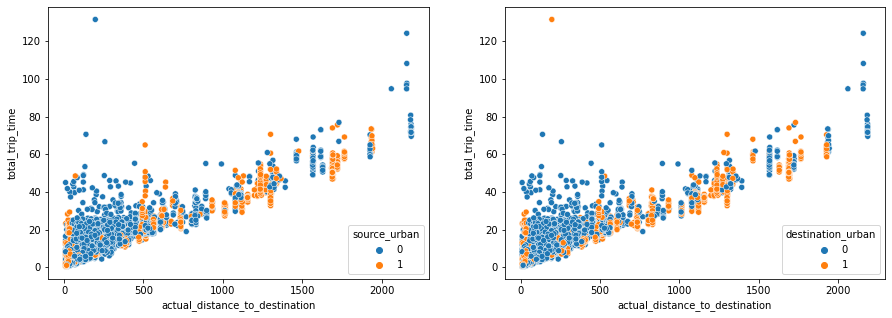

In [1097]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(data = df_agg, y = 'total_trip_time', x = 'actual_distance_to_destination', hue = 'source_urban')
plt.subplot(1,2,2)
sns.scatterplot(data = df_agg, y = 'total_trip_time', x = 'actual_distance_to_destination', hue = 'destination_urban')
plt.show()

<h4>If either or both source and destinations are metropolitan areas, the mean delivery times observed are much lesser, close to 8 hours.</h4>
<h4>However, for non metropolitan sources and destinations, the mean time rise above 10 hours, this shows that Delhivery might not be having alot of delivery stations close to some of these areas.</h4>

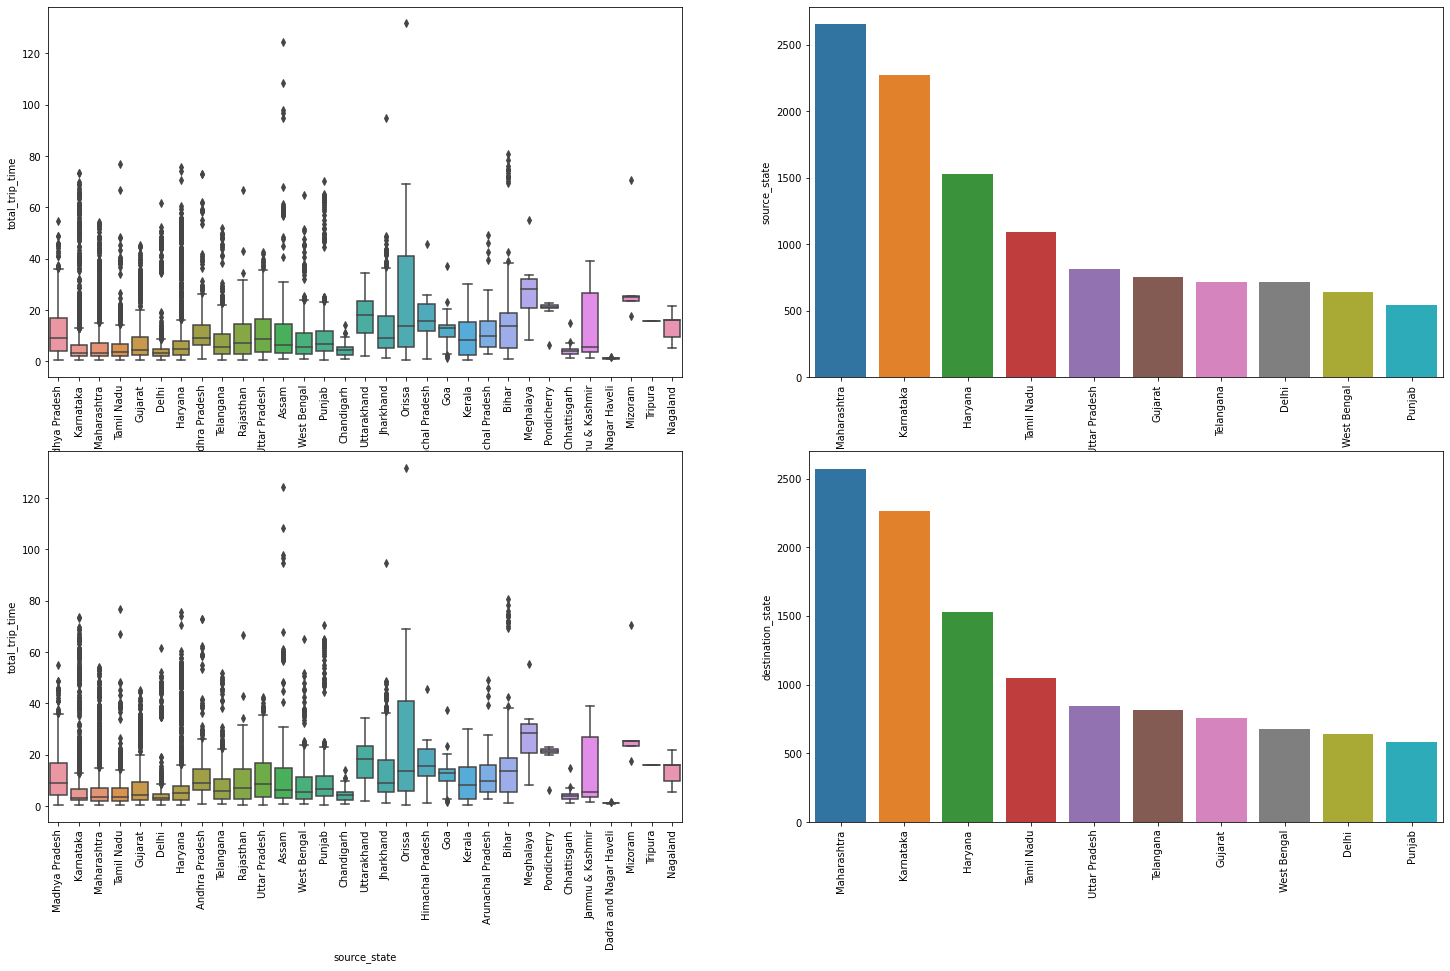

In [1208]:
plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
sns.boxplot(y = df_agg['total_trip_time'], x = df_agg['source_state'])
plt.xticks(rotation = 90)
plt.subplot(2,2,2)
sns.barplot(y = df_agg['source_state'].value_counts().head(10), x = df_agg['source_state'].value_counts().head(10).index)
plt.xticks(rotation = 90)
plt.subplot(2,2,3)
sns.boxplot(y = df_agg['total_trip_time'], x = df_agg['source_state'])
plt.xticks(rotation = 90)
plt.subplot(2,2,4)
sns.barplot(y = df_agg['destination_state'].value_counts().head(10), x = df_agg['destination_state'].value_counts().head(10).index)
plt.xticks(rotation = 90)
plt.show()

<h2 style = "color:red;">Observation</h2>

<h4>Mean trip times for all the sources states are shown above. As seen, top 10 most popular states are on the left side of the graph, therefore generally have lower trip times, considering Delhivery has more centers in these states as compared to others</h4>
<h4>States with non-uniform terrain like Mizoram, Himachal pradesh, Uttarakhand, J&K, Assam have high mean delivery times above 15 hours, this indicates that road development matters alot during delivery. This could also be due to higher number of FTL trips instead of carting trips to these states.</h4>
<h4>•Some popular states like Telangana, Punjab and West Bengal also have above or close to 10 hours delivery times, which is not suitable, so Delhivery should definitely ramp up the set up of more delivery hubs in these states and their accessible cities.</h4>

In [1336]:
s_cities = df_agg['source_city'].value_counts().head(15).index.values
d_cities = df_agg['destination_city'].value_counts().head(15).index.values

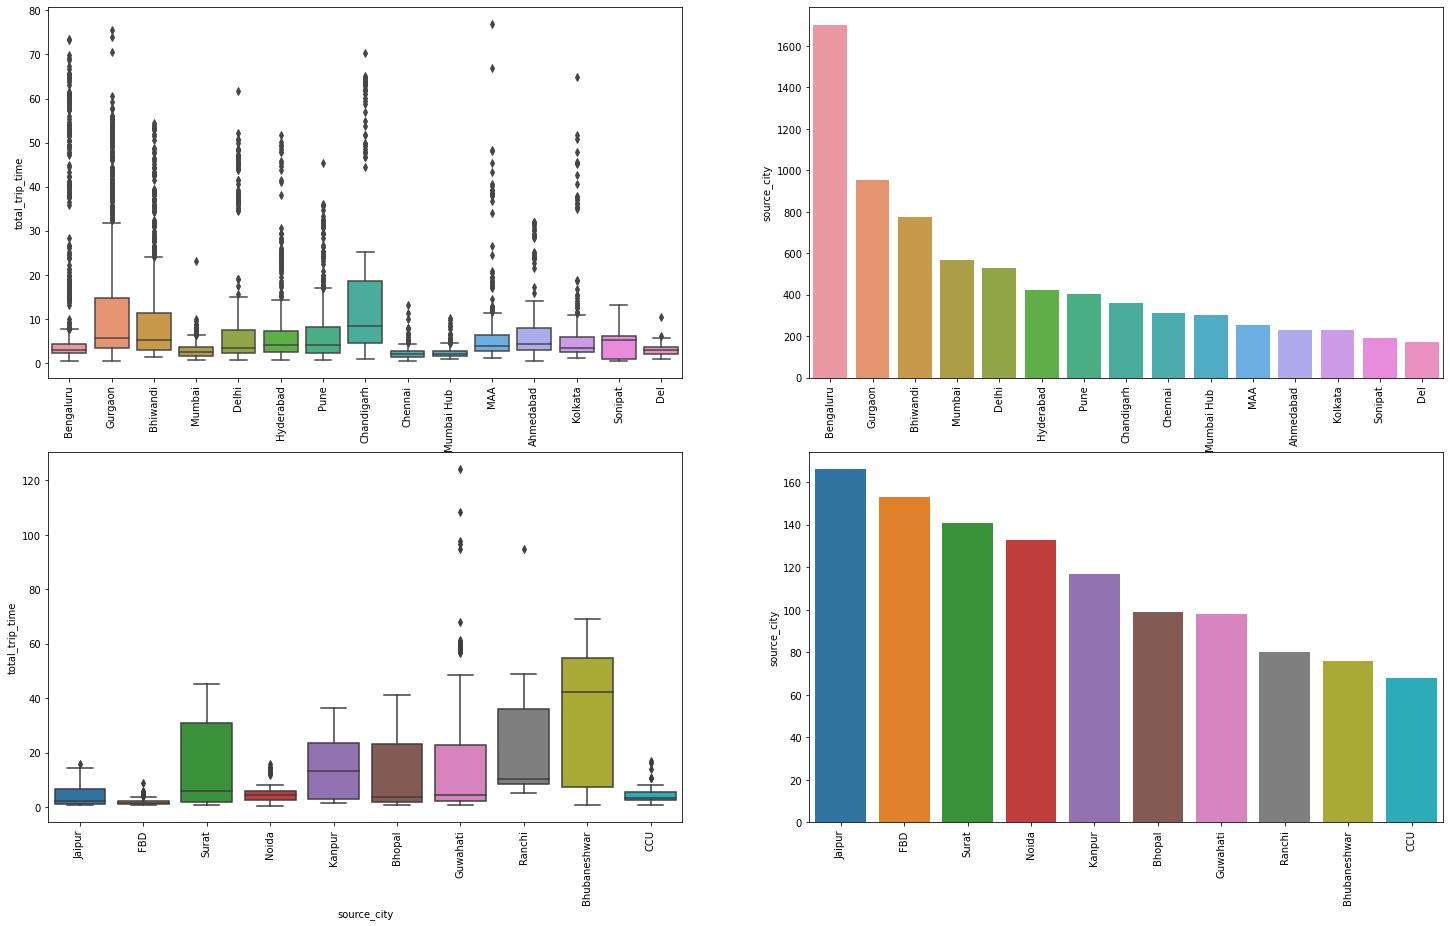

In [1383]:
plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
sns.boxplot(y = df_agg.set_index('source_city').loc[s_cities]['total_trip_time'], x = df_agg.set_index('source_city').loc[s_cities]['total_trip_time'].index)
plt.xticks(rotation = 90)
plt.subplot(2,2,2)
sns.barplot(y = df_agg['source_city'].value_counts().head(15), x = df_agg['source_city'].value_counts().head(15).index)
plt.xticks(rotation = 90)
plt.subplot(2,2,3)
sns.boxplot(y = df_agg.set_index('source_city').loc[df_agg['source_city'].value_counts()[15:25].index.values]['total_trip_time'], x = df_agg.set_index('source_city').loc[df_agg['source_city'].value_counts()[15:25].index.values]['total_trip_time'].index)
plt.xticks(rotation = 90)
plt.subplot(2,2,4)
sns.barplot(y = df_agg['source_city'].value_counts()[15:25], x = df_agg['source_city'].value_counts()[15:25].index)
plt.xticks(rotation = 90)
plt.show()

<h2 style = "color:red;">Observation</h2>

<h4>1. All cities that fall in the top 15 most popular from the data set are metropolitan cities or nearby areas. They have small trip time ranges and similar median total trip times which are mostly close to 5 hours. </h4>
<h4>2. The second group of top 15 cities also include some metropolitan but tend to have higher average trip times(10hours) and much higher range of values for total trip time variable(10 hours to 60 hours).</h4>
<h4>3. Metropolitan cities which fall under the second group in popularityy like Jaipur, Surat, Noida and FBD definitely need more delivery hubs establishments and efficient transport methods to bring a reduction in their trip times, as the distances are mostly similar to the top 15 popular cities. This will bring in more customers from these cities and also nearby areas, thus promising expansion of services. </h4>

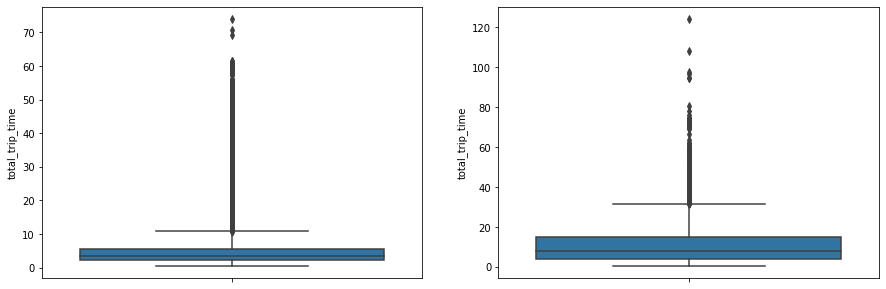

In [1393]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(y = df_agg[(df_agg.source_urban == 1) & (df_agg.destination_urban==1)]['total_trip_time'])
plt.subplot(1,2,2)
sns.boxplot(y = df_agg[(df_agg.source_urban == 0) & (df_agg.destination_urban==0)]['total_trip_time'])
plt.show()

In [1413]:
o1 = df_agg[(df_agg.source_urban == 1) & (df_agg.destination_urban==1)][['actual_distance_to_destination', 'source_city', 'destination_city','total_trip_time','route_type']]

In [1414]:
#Analysing routes where source and destination are both metropolitan and trip distance is less than 50kms
o1 = o1[o1['total_trip_time']> (np.percentile(o1['total_trip_time'],75)+1.5*iqr(o1['total_trip_time']))]
print(len(o1))
o1[o1['actual_distance_to_destination']<50].sample(20)

613


,actual_distance_to_destination,source_city,destination_city,total_trip_time,route_type
12673,45.955872,Delhi,Gurgaon,12.42,Carting
14783,25.640327,Kanpur,Kanpur,18.37,Carting
6530,24.812581,Kanpur,Kanpur,25.07,Carting
12485,35.763983,Kanpur,Kanpur,19.85,Carting
6053,46.444642,Delhi,Gurgaon,11.35,Carting
3792,20.347922,Kolkata,Kolkata,11.40,Carting
9476,45.923859,Delhi,Gurgaon,11.47,Carting
5109,25.102545,Kanpur,Kanpur,22.90,Carting
4583,46.507849,Delhi,Gurgaon,11.28,Carting
13061,23.993282,Kanpur,Kanpur,18.47,Carting


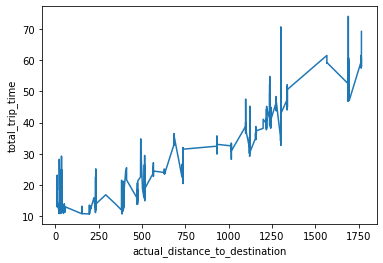

destination_city,Ahmedabad,Bengaluru,Chennai,Delhi,Gurgaon,Hyderabad,Jaipur,Kanpur,Kolkata,Kozhikode,Mumbai,Nashik,Noida,Pune,Surat
source_city,,,,,,,,,,,,,,,
Ahmedabad,0,0,0,0,17,0,11,0,0,0,0,0,0,0,2
Bengaluru,13,19,0,14,38,29,0,0,3,0,0,0,0,0,0
Chennai,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
Delhi,0,0,0,5,20,13,0,4,16,0,0,0,0,19,0
Gurgaon,17,47,0,1,0,16,11,9,32,0,0,0,0,3,0
Hyderabad,0,5,0,0,12,13,0,0,2,0,0,0,0,1,0
Jaipur,0,0,0,0,6,0,3,0,0,0,0,0,0,0,0
Kanpur,0,0,0,6,8,0,0,50,0,0,0,0,0,0,0
Kolkata,0,0,0,0,11,0,0,0,5,0,0,0,0,0,0


In [1422]:
plt.plot(o1.sort_values(by=['actual_distance_to_destination','total_trip_time'])['actual_distance_to_destination'], o1.sort_values(by=['actual_distance_to_destination','total_trip_time'])['total_trip_time'])
plt.xlabel('actual_distance_to_destination')
plt.ylabel('total_trip_time')
plt.show()
pd.crosstab(index = o1['source_city'], columns = o1['destination_city'])

<h2 style = "color:red;">Observation</h2>

<h4>There are 613 trips, where both source and destination cities are metropolitan but trip times fall in the outlier range of greater than 10 hours. As visible from the above graph, these are trips with majority of trip distances above 250 kms till 2000kms.</h4>
<h4>Kanpur->kanpur has 50 trips which fall in the outliers for trip time. Delhi-Gurgaon has 20 trips, and some trips have distances less than 45kms, still the delivery times are more than 10 hours</h4>
<h4>• There is operational lag in the delivery system at Delhivery for trip distances<50kms within the same city. Instead of self managing carting trips for these cases, Delhivery should outsource pick and drop tasks to businesses like Porter/Wefast, to achieve minimal trip times in this category of trips so people start preferring them over the competition.</h4>
<h4>• Delhivery can also introduce a system similar to Swiggy genie for short distance quick trips and retain more focus on optimization of long FTL trips</h4>

In [1427]:
pd.crosstab(index = df_agg['route_type'], columns = df_agg['destination_urban'])

destination_urban,0,1
route_type,,
Carting,3994,4914
FTL,4597,1312


In [1428]:
pd.crosstab(index = df_agg['route_type'], columns = df_agg['source_urban'])

source_urban,0,1
route_type,,
Carting,3911,4997
FTL,4722,1187


<h4>There are less than 1500 FTL trips when source or destination is urban, however, no. of carting trips for both scenarios are almost 4 times.</h4>
<h4>Almost equivalent ratio is observed for carting and FTL trips when source/destination are not metropolitan</h4>

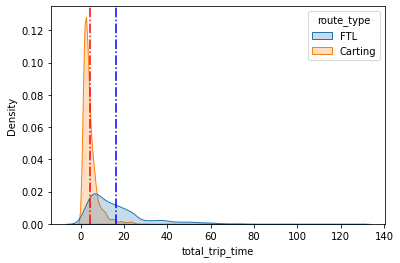

In [1361]:
sns.kdeplot(df_agg['total_trip_time'], hue = df_agg['route_type'], fill = True)
plt.axvline(x = df_agg[df_agg['route_type'] == 'FTL']['total_trip_time'].mean(), linestyle = '-.', color = 'b')
plt.axvline(x = df_agg[df_agg['route_type'] == 'Carting']['total_trip_time'].mean(), linestyle = '-.', color = 'r')
plt.show()

<h4>Difference in mean trip times of carting and FTL trips is almost 10 hours.</h4>

In [1122]:
def bootstrap_means(df, n , r):
    mean_arr = [np.mean(df.sample(n, replace = True).values) for i in range(r)]
    return mean_arr

In [1152]:
#Assumption 1: Sample means follow gaussian distribution
def normality_check(df, rv1, rv2):
    sm1 = bootstrap_means(df_agg[rv1], 200, 1000)
    sm2 = bootstrap_means(df_agg[rv2], 200, 1000)
    sns.distplot(sm1)
    sns.distplot(sm2)
    plt.legend([rv1, rv2])
    st1 = shapiro(sm1)
    st2 = shapiro(sm2)
    return sm1,sm2,st1,st2

In [1153]:
#Assumption: Sample means and standard deviation are finite
def finite_check(df, rv1, rv2):
    sm1,sm2,st1,st2 = normality_check(df,rv1,rv2)
    m1 = np.mean(sm1)
    m2 = np.mean(sm2)
    sd1 = np.std(sm1)
    sd2 = np.std(sm2)
    return m1,m2,sd1,sd2,st1,st2

<h3>Scanner start to end time vs Total trip time</h3>

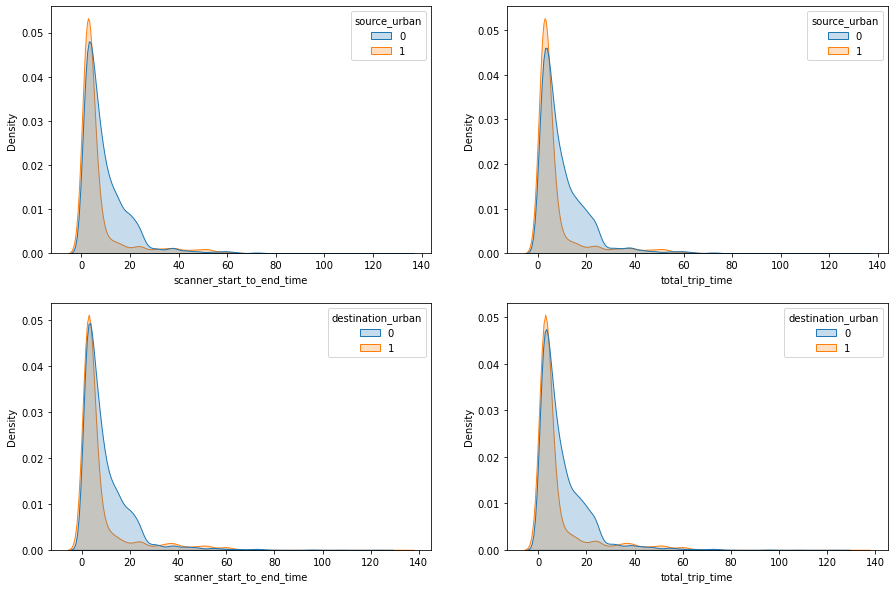

In [1121]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
sns.kdeplot(df_agg['scanner_start_to_end_time'], fill = True, hue = df_agg['source_urban'])
plt.subplot(2,2,2)
sns.kdeplot(df_agg['total_trip_time'], fill = True, hue = df_agg['source_urban'])
#plt.legend(labels = ['Predicted Trip Time','Calculated Trip Time'])
plt.subplot(2,2,3)
sns.kdeplot(df_agg['scanner_start_to_end_time'], fill = True, hue = df_agg['destination_urban'])
plt.subplot(2,2,4)
sns.kdeplot(df_agg['total_trip_time'], fill = True, hue = df_agg['destination_urban'])
plt.show()

<h2 style = "color:red;">Observation</h2>

<h4>Very identical graphs are observed for both scanned and calculated time variable depending on the source/destination being urban or not.</h4>
<h4>Its highly likely that both variables are following the same distribution and the mean values are very close</h4>
<h4>This can be confirmed using a T-test comparing both sample means of the variables scanner start to end time and total trip time</h4>

<h3 style="color:orange;">2 sample T-test</h3>

<h4>Null Hypothesis--> </h4>
<h4>H0 = Average scanner start to end time = Average calculated total trip time.</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Average scanner start to end time != Average calculated total trip time.</h4>

<h4>Performing Shapiro wilk test to check normality of sample mean arrays for both variables, threshold α=0.05</h4>
<h4>H0 = Data closely follow normal distribution</h4>
<h4>H1 = Data is very different from normal distribution</h4>

<h4>Close to 95% sample means follow gaussian distribution and Population mean and standard devations are finite. So both assumptions are satisfied.</h4>

Population Means:|8.8435519|9.133444500000001
Population Standard Deviations:|0.7726458383220542|0.8286728630254221
Shapiro Test1: ShapiroResult(statistic=0.9978413581848145, pvalue=0.22241903841495514)
Shapiro Test2: ShapiroResult(statistic=0.9977032542228699, pvalue=0.17941030859947205)


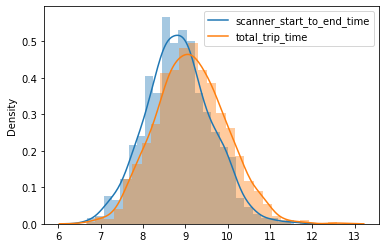

In [1156]:
m1,m2,sd1,sd2,st1,st2 = finite_check(df_agg, 'scanner_start_to_end_time', 'total_trip_time')
print('Population Means:', m1,m2, sep = '|')
print('Population Standard Deviations:', sd1,sd2, sep = '|')
print('Shapiro Test1:', st1)
print('Shapiro Test2:', st2)

<h4>α>5%, for both shapiro wilk tests and population mean and standard deviations observed are finite, so t-test can be performed</h4>

In [1158]:
ttest_ind(df_agg['scanner_start_to_end_time'].sample(300),df_agg['total_trip_time'].sample(300))

Ttest_indResult(statistic=0.6940404680429705, pvalue=0.48792634803773893)

<h2 style = "color:red;">Observation</h2>

<h4>Since α>5% for the observed test statistic value of 0.69, therefore, we fail to the reject the null hypothesis.</h4>
    
**•There is no difference between Scanner start to end time and Total trip time**

<h3>Actual time vs OSRM time</h3>

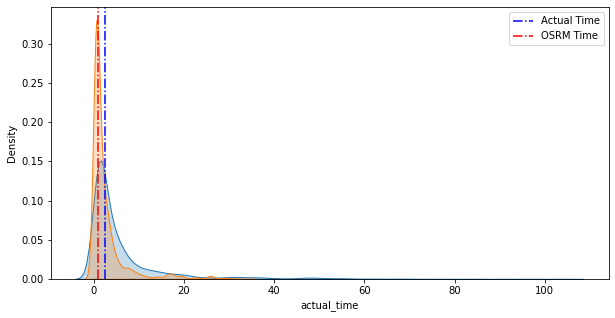

In [1356]:
plt.figure(figsize = (10,5))
sns.kdeplot(df_agg['actual_time'], fill = True)
plt.axvline(x = df_agg['actual_time'].median(), linestyle = '-.', color = 'b')
sns.kdeplot(df_agg['osrm_time'], fill = True)
plt.axvline(x = df_agg['osrm_time'].median(), linestyle = '-.', color = 'r')
plt.legend(labels = ['Actual Time','OSRM Time'])
plt.show()

<h2 style = "color:red;">Observation</h2>

<h4>Even though the peaks are very close with respect to the values, the peak density is very high for OSRM time compared to Actual time.</h4>
<h4>The distributions are very similar but the peakedness of OSRM distribution indicates there is a difference in values</h4>
<h4>This can be confirmed using a T-test comparing both sample means of the variables Actual time and OSRM time</h4>

<h3 style="color:orange;">2 sample T-test</h3>

<h4>Null Hypothesis--> </h4>
<h4>H0 = Average Actual time = Average OSRM time.</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Average Actual time != Average OSRM.</h4>

<h4>Performing Shapiro wilk test to check normality of sample mean arrays for both variables, threshold α=0.05</h4>
<h4>H0 = Data closely follow normal distribution</h4>
<h4>H1 = Data is very different from normal distribution</h4>

Population Means:|5.98377545|2.70437715
Population Standard Deviations:|0.6669718180026781|0.32620783342890086
Shapiro Test1: ShapiroResult(statistic=0.997165858745575, pvalue=0.07517828047275543)
Shapiro Test2: ShapiroResult(statistic=0.9983400702476501, pvalue=0.4548022747039795)


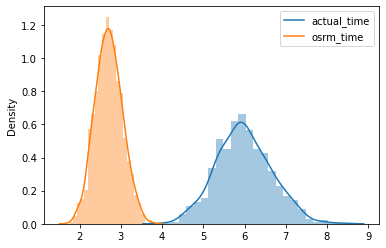

In [1167]:
m1,m2,sd1,sd2,st1,st2 = finite_check(df_agg, 'actual_time', 'osrm_time')
print('Population Means:', m1,m2, sep = '|')
print('Population Standard Deviations:', sd1,sd2, sep = '|')
print('Shapiro Test1:', st1)
print('Shapiro Test2:', st2)

<h4>α>5%, for both shapiro wilk tests and population mean and standard deviations observed are finite, so t-test can be performed</h4>

In [1168]:
ttest_ind(df_agg['actual_time'].sample(300),df_agg['osrm_time'].sample(300))

Ttest_indResult(statistic=6.050619108448994, pvalue=2.5458854729404617e-09)

<h2 style = "color:red;">Observation</h2>

<h4> α<5%,therefore null hypothesis can be rejected. So OSRM time gives different values compared to actual time.</h4>
<h4>•This indicates that the intelligently computed time with the algorithm (OSRM time) definitely ignores alot of parameters and needs to be further refined to match with actual time. Or drivers have to take different routes covering different distances than the anticipated ones.</h4>
<h4>Anticipated distances and actual distance variable can be compared to get the proof for difference in the routes, therefore difference in actual time and osrm time</h4>

<h3>Actual Distance to destination vs OSRM distance</h3>

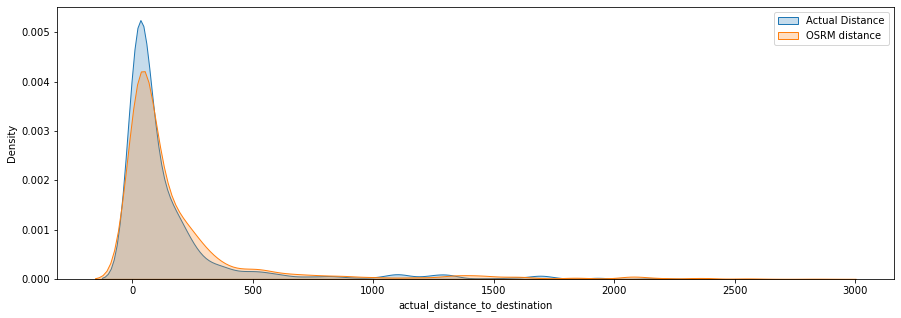

In [1184]:
plt.figure(figsize = (15,5))
sns.kdeplot(df_agg['actual_distance_to_destination'], fill = True)
sns.kdeplot(df_agg['osrm_distance'], fill = True)
plt.legend(labels = ['Actual Distance','OSRM distance'])
plt.show()

<h4>It is evident after seeing the distributions that the values for Actual distance and segment OSRM distance would probably be different. So t-test will be helpful in confirming this</h4>
<h4>H0: Actual distance mean = OSRM distance mean</h4>
<h4>H1: Actual distance mean != OSRM distance mean</h4>

In [1197]:
ttest_ind(df_agg['actual_distance_to_destination'].sample(1000),df_agg['osrm_distance'].sample(1000))

Ttest_indResult(statistic=-2.5151679207228974, pvalue=0.011975478302163747)

<h2 style = "color:red;">Observation</h2>

<h4>As anticipated, the null hypothesis has to rejected since α<5% and therefore, there is a definite difference in the route taken by driver when compared to OSRM distance during the trips.</h4>
<h4>• Hence, Delhivery should refine the algorithm for calculation of the OSRM distance to include the most optimal real time route for time and distance calculation.</h4>
<h4>• Another method is to incentivize drivers to take the calculated optimal route and collect more data, do further analysis on updated route, then revise the model</h4>

<h3>Actual Time vs Segment actual time</h3>

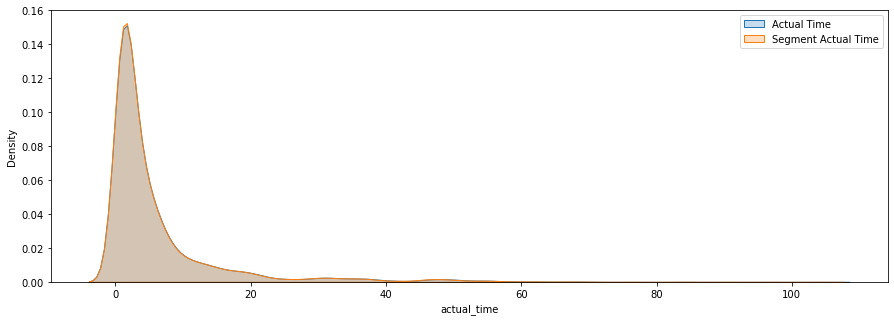

In [1201]:
plt.figure(figsize = (15,5))
sns.kdeplot(df_agg['actual_time'], fill = True)
sns.kdeplot(df_agg['segment_actual_time'], fill = True)
plt.legend(labels = ['Actual Time','Segment Actual Time'])
plt.show()

<h2 style="color:orange;">KS Test</h2>
<h4>As seen above, the distributions are very identical, there is no visible difference between the two.</h4>
<h4>To confirm if both variables are same, KS test will be used with 95% confidence to reject null hypothesis</h4>

<h4>Null Hypothesis--> </h4>
<h4>H0 = Actual time distribution is same as Segment actual time distribution</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Actual time distribution is different from Segment actual time distribution</h4>

In [1230]:
kstest(df_agg['actual_time'].sample(1000), df_agg['segment_actual_time'].sample(1000))

KstestResult(statistic=0.04, pvalue=0.4006338815832625)

<h2 style = "color:red;">Observation</h2>

<h4>p-value = 0.40, therefore α>5% for 1000 samples</h4>
<h4>Both the random variables Actual time and Segment actual time follow the same distribution, therefore they have near identical values</h4>

<h3>OSRM distance vs Segment OSRM distance</h3>

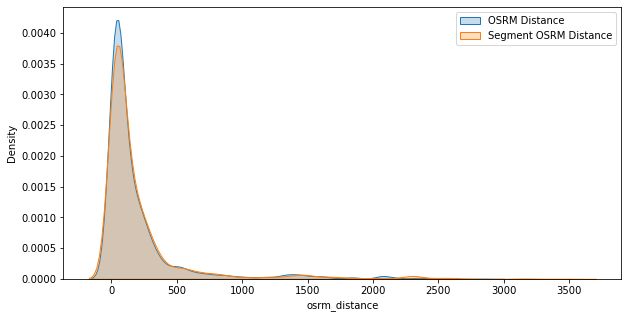

In [1214]:
plt.figure(figsize = (10,5))
sns.kdeplot(df_agg['osrm_distance'], fill = True)
sns.kdeplot(df_agg['segment_osrm_distance'], fill = True)
plt.legend(labels = ['OSRM Distance','Segment OSRM Distance'])
plt.show()

<h4>As seen above, the distributions are very identical, there is no visible difference between the two.</h4>
<h4>To confirm if both variables are same, KS test will be used with 95% confidence to reject null hypothesis</h4>
<h4>Null Hypothesis--> </h4>
<h4>H0 = Osrm distance distribution is same as Segment osrm distance distribution</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Osrm distance distribution is different from Segment osrm distance distribution</h4>

In [1228]:
print('500 samples: ')
print(kstest(df_agg['osrm_distance'].sample(500), df_agg['segment_osrm_distance'].sample(500)))
print('1000 samples: ')
print(kstest(df_agg['osrm_distance'].sample(1000), df_agg['segment_osrm_distance'].sample(1000)))
print('5000 samples: ')
print(kstest(df_agg['osrm_distance'].sample(5000), df_agg['segment_osrm_distance'].sample(5000)))

500 samples: 
KstestResult(statistic=0.034, pvalue=0.9351121874342835)
1000 samples: 
KstestResult(statistic=0.081, pvalue=0.0028179208242694134)
5000 samples: 
KstestResult(statistic=0.037, pvalue=0.002127664129050972)


<h2 style = "color:red;">Observation</h2>

<h4>α<5% for sample sizes greater than 500, so the test while α>5% for 500 samples. So, KS test is inconclusive</h4>
<h4>T-test can be performed to confirm sample means are similar</h4>

<h3 style="color:orange;">2 sample T-test</h3>

<h4>Null Hypothesis--> </h4>
<h4>H0 = Average OSRM distance = Average Segment OSRM distance.</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Average OSRM distance != Average Segment OSRM distance.</h4>

<h4>Performing Shapiro wilk test to check normality of sample mean arrays for both variables, threshold α=0.05</h4>
<h4>H0 = Data closely follow normal distribution</h4>
<h4>H1 = Data is very different from normal distribution</h4>

Population Means:|205.434485809|223.467705303
Population Standard Deviations:|26.144266296740685|28.76685675186743
Shapiro Test1: ShapiroResult(statistic=0.9979221224784851, pvalue=0.25154322385787964)
Shapiro Test2: ShapiroResult(statistic=0.9962894320487976, pvalue=0.017621146515011787)


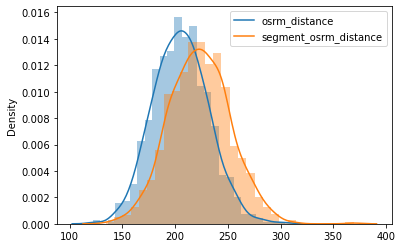

In [1243]:
m1,m2,sd1,sd2,st1,st2 = finite_check(df_agg, 'osrm_distance', 'segment_osrm_distance')
print('Population Means:', m1,m2, sep = '|')
print('Population Standard Deviations:', sd1,sd2, sep = '|')
print('Shapiro Test1:', st1)
print('Shapiro Test2:', st2)

<h4>Both sample mean distributions are close to gaussian and population mean and std are finite, so t-test can be performed</h4>

In [1293]:
ttest_ind(df_agg['osrm_distance'].sample(5000),df_agg['segment_osrm_distance'].sample(5000))

Ttest_indResult(statistic=-1.6318962248855773, pvalue=0.10273284290144119)

<h2 style = "color:red;">Observation</h2>
<h4>p-value = 0.10, since α>5%, failure to reject null hypothesis indicates:</h4>
<h4>Sample means for size of 1000 samples are similar for OSRM distance and Segment OSRM distance.</h4>
<h4>So, OSRM distance and segment osrm distance follow similar values.</h4>

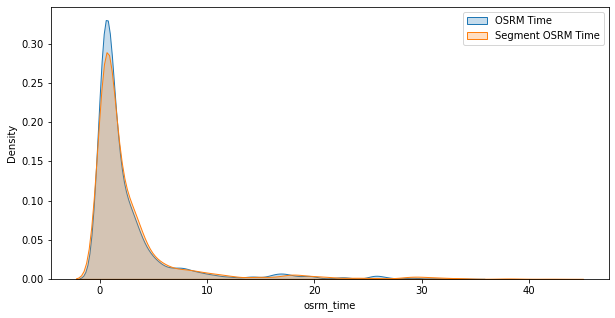

In [1061]:
plt.figure(figsize = (10,5))
#plt.subplot(1,2,1)
sns.kdeplot(df_agg['osrm_time'], fill = True)
#plt.subplot(1,2,2)
sns.kdeplot(df_agg['segment_osrm_time'], fill = True)
plt.legend(labels = ['OSRM Time','Segment OSRM Time'])
plt.show()

<h4>As seen above, the distributions are very identical, there is no visible difference between the two.</h4>
<h4>To confirm if both variables are same, KS test will be used with 95% confidence to reject null hypothesis</h4>
<h4>Null Hypothesis--> </h4>
<h4>H0 = Osrm time distribution is same as Segment osrm time distribution</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Osrm time distribution is different from Segment osrm time distribution</h4>

In [1258]:
print('500 samples: ')
print(kstest(df_agg['osrm_time'].sample(500), df_agg['segment_osrm_time'].sample(500)))
print('1000 samples: ')
print(kstest(df_agg['osrm_time'].sample(1000), df_agg['segment_osrm_time'].sample(1000)))
print('5000 samples: ')
print(kstest(df_agg['osrm_time'].sample(5000), df_agg['segment_osrm_time'].sample(5000)))

500 samples: 
KstestResult(statistic=0.048, pvalue=0.6126241113875229)
1000 samples: 
KstestResult(statistic=0.042, pvalue=0.34112475112661245)
5000 samples: 
KstestResult(statistic=0.0316, pvalue=0.013568763904229907)


<h4>As seen above, for sample size of 5000, the p-value obtained is less than 5%, so KS test is not giving the appropriate confirmation</h4>
<h4>Directly performing t-test for Null Hypothesis--> </h4>
<h4>H0 = Average Osrm time is same as AverageSegment osrm time</h4>
<h4>Alternative Hypothesis--> Requiring confirmation with 95% confidence</h4>
<h4>H1 = Average Osrm time is different from Average Segment osrm time</h4>

In [1296]:
ttest_ind(df_agg['osrm_time'].sample(5000), df_agg['segment_osrm_time'].sample(5000))

Ttest_indResult(statistic=-2.7210905523812072, pvalue=0.0065179539081594365)

<h2 style = "color:red;">Observation</h2>
<h4>p-value = 0.0065, since α<5%, Null hypothesis has to be rejected</h4>
<h4>Sample means for size of 5000 samples are very different for OSRM time and Segment OSRM time.</h4>
<h4>This indicates that package based calculated time varies with regards to segment osrm time</h4>

<h2>Standardization of numerical features for machine learning based studies:</h2>

In [1307]:
ncol = [c for c in df_agg.columns if df_agg[c].dtype == 'float64']

In [1310]:
scaler = StandardScaler()
std_data = scaler.fit_transform(df_agg[ncol])
std_data = pd.DataFrame(std_data, columns = ncol)

In [1312]:
for c in ncol:
    dfn[c] = std_data[c]  

<h2 style="color:Purple;">Key Insights</h2>

<h4>1. 'dfn' is the dataframe with all numerical columns standardized using StandardScaler and all categorical columns converted to numerical for developing the machine learning forecasting models as required by Delhivery.</h4>
<h4>2. 'df_agg' is the aggregated dataframe based on the trip ID and categorical variables are maintained as categorical for future reference.</h4>
<h4>3. Average trip time is 547 minutes, almost twice of the median value. This indicates outliers or largely sparse data for a certain category</h4>
<h4>4.Trip distances have ranged from 9kms to 2187 kms with an average of 164 kms</h4>
<h4>5. Full Truck load trips have a mean trip time of above 16 hours, and mean travel distances of 350 kms. Carting trips are shorter within 50kms distance and less than 5 hours of travel time</h4>
<h4>6. States with non-uniform terrain like Mizoram, Himachal pradesh, Uttarakhand, J&K, Assam have high mean delivery times above 15 hours, this indicates that road development matters alot during delivery. This could also be due to higher number of FTL trips instead of carting trips to these states.</h4>
<h4>7. There are 613 trips, where both source and destination cities are metropolitan but trip times fall in the outlier range of greater than 10 hours. As visible from the above graph, these are trips with majority of trip distances above 250 kms till 2000kms.</h4>
<h4>8. Kanpur->kanpur has 50 trips which fall in the outliers for trip time. Delhi-Gurgaon has 20 trips, and some trips have distances less than 45kms, still the delivery times are more than 10 hours.</h4>
<h4>9. There are less than 1500 FTL trips when source or destination is urban, however, no. of carting trips for both scenarios are almost 4 times.</h4>
<h4>10. Almost equivalent ratio is observed for carting and FTL trips when source/destination are not metropolitan.</h4>
<h4>11. For non metropolitan sources and destinations, the mean time rise above 10 hours, this shows that Delhivery might not be having alot of delivery stations close to some of these areas. </h4>
<h4>12. There is no difference between Scanner start to end time and Total trip time</h4>
<h4>13. So OSRM time calculator gives different values compared to actual time. </h4>
<h4>14. There is a definite difference in the route taken by driver when compared to OSRM distance during the trips.</h4>
<h4>15. Both the random variables Actual time and Segment actual time follow the same distribution, therefore they have near identical values</h4>
<h4>16. OSRM distance and segment osrm distance follow similar values.
<h4>17. Package based(Segment osrm) calculated time varies with regards to trip Osrm time.</h4>
<h2 style="color:Purple;">Recommedations</h2>

<h4>• Some popular states like Telangana, Punjab and West Bengal also have above or close to 10 hours delivery times, which is not suitable, so Delhivery should definitely ramp up the set up of more delivery hubs in these states and their accessible cities.</h4>
<h4>• Intelligently computed time with the algorithm (OSRM time) definitely ignores alot of parameters and needs to be further refined to match with actual time. Or drivers have to take different routes covering different distances than the anticipated ones.</h4>
<h4>• Hence, Delhivery should refine the algorithm for calculation of the OSRM distance to include the most optimal real time route for time and distance calculation.</h4>
<h4>• Another method is to incentivize drivers to take the calculated optimal route and collect more data, do further analysis on updated route, then revise the model</h4>
<h4>• Metropolitan cities which fall under the second group in popularityy like Jaipur, Surat, Noida and FBD definitely need more delivery hubs establishments and efficient transport methods to bring a reduction in their trip times, as the distances are mostly similar to the top 15 popular cities. This will bring in more customers from these cities and also nearby areas, thus promising expansion of services.</h4>
<h4>• There is operational lag in the delivery system at Delhivery for trip distances<50kms within the same city. Instead of self managing carting trips for these cases, Delhivery should outsource pick and drop tasks to businesses like Porter/Wefast, to achieve minimal trip times in this category of trips so people start preferring them over the competition.</h4>
<h4>• Delhivery can also introduce a system similar to Swiggy genie for short distance quick trips and retain more focus on optimization of long FTL trips.</h4>